# Processament del Llenguatge Humà Pràctica 1: Identificador d'idioma 

<div style="text-align: justify;">
En aquesta pràctica, el nostre objectiu és determinar en quin dels sis idiomes europeus—anglès, castellà, neerlandès, alemany, italià o francès—estan escrites una sèrie de frases.

Per fer-ho, utilitzarem un model basat en trigrames, seqüències de tres caràcters consecutius dins d’un text que ens ajuden a identificar patrons característics de cada idioma.

Aquest model es crearà a partir dels textos d’entrenament de cada llengua i s’aplicarà la tècnica de suavitzat de Lidstone per assignar probabilitats als trigrames.
Un cop creats els models, els farem servir per identificar l’idioma de noves frases, escollint aquell amb la probabilitat més alta. Finalment, compararem els resultats amb els idiomes reals i avaluarem la precisió del model mitjançant una matriu de confusió.
</div>

In [1]:
import re
import os
import nltk
from nltk.collocations import TrigramCollocationFinder
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


<div style="text-align: justify;">
Per començar, importem cadascun dels arxius de train dels que disposem, un per a cada idioma, i els guardem en un diccionari utilitzant les sigles de l'idioma al que pertany cadascun com a clau, i el contingut de cada arxiu com a valor relatiu a aquesta clau.

Això ens permet accedir fàcilment al text d'entrenament de cada idioma.
</div>

In [2]:
archivos_entrada = ("spa_trn.txt", "eng_trn.txt", "deu_trn.txt", "fra_trn.txt", "ita_trn.txt", "nld_trn.txt")

contenidos = {}
for archivo in archivos_entrada:
    idioma = archivo.split("_")[0]  
    
    with open(archivo, "r", encoding="utf-8") as f:
        contenidos[idioma] = f.read()

# Funcions

A continuació, definim les funcions que s'utilitzen al llarg del codi per a dur a terme la tasca.

<div style="text-align: justify;">
<h3>Preprocessament dels textos</h3>
En aquesta primera funció, definim totes les transformacions que cal aplicar als textos que llegim, tant els de train com els que contenen les frases a identificar.
L'objectiu és assegurar que les dades estiguin en un format uniforme per millorar la precisió del model i reduir el soroll que podria afectar les prediccions.  

Les transformacions que apliquem al document processat són:
- Eliminació dels digits presents (incloent els espais que segueixen a aquests digits, per tal d'evitar espais dobles no desitjats)
- Transformació de totes les lletres a format minúscula
- Eliminació d'espais innecessaris, tabuladors
- Substitució dels salts de línea per dos espais en blanc, utilitzant aquests com a separadors entre frases

La funció retorna el text ja processat.
</div>

In [3]:
def preprocesar_texto(texto):
    texto = re.sub(r"\d\s*", "", texto)  # Eliminar dígits
    texto = texto.lower()  # Convertir a minúscules
    texto = texto.replace("\t", "")  # Eliminar tabuladors
    texto = re.sub(r"\n", "  ", texto)  # Substituir salts de línia amb doble espai
    return texto

<div style="text-align: justify;">
<h3>Lectura del document a identificar</h3>
Aquesta funció es divideix en dues parts principals:

1. La lectura del document.  

2. L’anàlisi dels trigrames de cadascuna de les frases del text.



Primerament, un cop hem llegit el document en qüestió, es crida a la funció de preprocessamet previament explicada per a que ajusti les dades d'aquest per a tenir-les en el format correcte per al seu tractament posterior. A continuació, separem les frases utilitzant com a referència els dos espais continus que hem utilitzat per a delimitar cada frase en el processament.
Posteriorment, per cadascuna de les frases, busquem els seus trigrames i guardem la informació en el següent format:
- Una llista de diccionaris frase-trigrames
- Una llista amb les frases del text
- Una lista amb l'idioma al qual pertany la frase

D'aquesta manera, la funció ens retorna la llista de diccionaris amb totes les frases i els seus trigrames, i a més les altres dos llistes que utilitzarem posteriorment (més concretament la de l'idioma de cada frase) per a validar el nostre projecte.
</div>

In [4]:
def lectura_frases_input(texto):
    idioma_real = os.path.basename(texto).split("_")[0]
    with open(texto, "r", encoding="utf-8") as f:
        input_texto = f.read()
    texto_procesado = preprocesar_texto(input_texto)
    frases = re.split(r'  ', texto_procesado)  # Divideix frases on hi hagin 2 espais seguits

    trigramas_por_frase = []  
    frases_test = []  
    idioma_frases = []
    
    for frase in frases:
        if frase:  
            finder_in = TrigramCollocationFinder.from_words(list(frase)) 
            frases_test.append(frase)
            idioma_frases.append(idioma_real)
            trigramas_por_frase.append({'frase': frase, 'trigramas': dict(finder_in.ngram_fd.items())})  # Guardaem frase i els seus trigrames
    
    return trigramas_por_frase, frases_test, idioma_frases  


<div style="text-align: justify;">
<h3>Càlcul de la log-probabilitat d'una frase en un idioma</h3>

Aquesta funció té com a objectiu calcular la log-probabilitat d'una frase en un idioma determinat, utilitzant el suavitzat de Lidstone. Això ens permet estimar la probabilitat d'aparició d'una seqüència de trigrames en un idioma concret, fins i tot quan alguns trigramas no han aparegut en les dades d'entrenament.

Per fer-ho, utilitzem la següent fórmula del suavitzat de Lidstone per calcular la probabilitat d'un trigrama <i>T</i> dins d'un model d'idioma:
$$
P(T) = \frac{c_T(e_j) + \lambda}{N_T + \lambda B}
$$
on:
- $c_T(e_j)$ és lLa freqüència d'aparició del trigrama $e_j$ en el corpus d'entrenament en l'idioma $T$.
- $N_T$ és el nombre total de trigramas en el model de l'idioma $T$.
- $B$ és el nombre total de trigramas diferents en el model.
- $\lambda$ és el paràmetre de suavitzat de Lidstone, que evita que trigramas no vistos tinguin probabilitat zero.

Per obtenir la probabilitat total de la frase, sumem la log-probabilitat de cada trigrama ponderada per la seva freqüència en la frase:

$$
\log P(\text{frase}) = \sum_{T} f_T \cdot \log P(T)
$$

on $ f_T $ representa la freqüència del trigrama en la frase.

Aquesta funció recorre tots els trigramas de la frase, calcula la seva probabilitat amb suavitzat de Lidstone i acumula la suma de log-probabilitats ponderades. El resultat final ens indica la probabilitat relativa de la frase en un idioma determinat.</div>


In [5]:
LAMBDA = 0.5  # Suavizado de Lidstone

def calcular_log_probabilidad(trigramas_frase, modelo_trigramas):
    """Calcula la log-probabilidad de una frase en un idioma usando suavizado de Lidstone."""
    N_T = sum(modelo_trigramas.values())  # Total de trigramas en el modelo
    B = len(modelo_trigramas)  # Número total de trigramas distintos

    log_prob = 0
    for trigrama, f_ej in trigramas_frase.items():  # Recorremos trigramas de la frase
        c_T = modelo_trigramas.get(trigrama, 0)  # Frecuencia del trigrama en el modelo del idioma
        P_T = (c_T + LAMBDA) / (N_T + LAMBDA * B)  # Aplicamos suavizado de Lidstone
        log_prob += f_ej * np.log(P_T)  # Sumamos log-probabilidad ponderada por frecuencia
    
    return log_prob

<div style="text-align: justify;">
<h3>Identificació de l'idioma d'una frase</h3>

Aquesta funció té com a objectiu predir l'idioma d'una sèrie de frases basant-se en la probabilitat màxima previament calculada amb el suavitzat de Lidstone. Per fer-ho, compara la log-probabilitat de cada frase en cadascun dels idiomes disponibles i selecciona aquell amb la puntuació més alta.

Per cada frase:
- Extraiem els trigramas que la componen.
- Per a cada idioma del model, calculem la log-probabilitat de la frase en aquell idioma.
- Guardem la probabilitat de la frase per a cada idioma en un diccionari.
- Afegim el resultat a una llista per retornar totes les prediccions.


Com hem vist abans, la probabilitat de cada frase en un idioma es calcula amb la funció:

$$\log P^T(\text{frase}) = \sum_{T} f_T \cdot \log P^T(T)$$


Un cop tenim totes les log-probabilitats, triem l'idioma amb el valor més alt:

$$
T^* = \max_T \log P^T(\text{frase})
$$

Això ens assegura que la frase sigui assignada a l'idioma en què és més probable segons els trigramas observats.

La funció retorna una llista de diccionaris, on cada element té:

- 'frase': El text original de la frase.
- 'idioma': L’idioma predit per al text.


Aquesta estratègia ens permet classificar eficientment frases en diferents idiomes amb una alta precisió.</div>


In [6]:
def identificar_idioma(frases_trigramas, modelos_idioma):
    """Predice el idioma de cada frase usando la probabilidad máxima con suavizado de Lidstone."""
    resultados = []

    for item in frases_trigramas:  # Recorremos todas las frases
        frase = item['frase']
        trigramas_frase = item['trigramas']
        
        probabilidades = {}
        for idioma, modelo_trigramas in modelos_idioma.items():
            log_prob = calcular_log_probabilidad(trigramas_frase, modelo_trigramas)
            probabilidades[idioma] = log_prob

        mejor_idioma = max(probabilidades, key=probabilidades.get)  # Elegimos el idioma con mayor probabilidad
        resultados.append({'frase': frase, 'idioma': mejor_idioma})
    
    return resultados

# Execució del model

<div style="text-align: justify;">
En aquest apartat es porta a terme la implementació de les funcions anteriors per a la possible realització del model d'identificació de llenguatge. 


Com a primer pas, s'aplica el preprocessament abans descrit al diccionari inicial format per l'id del idioma com a clau i l'arxiu 'train' corresponent com a valor, generant així per a cadascun d'aquests els seus trigramas més freqüents, donat que s'eliminen aquells que apareixen 5 o menys vegades, guardant el resultat final, és a dir, els diversos models de llenguatge, en un diccionari amb el nom de l'arxiu com a clau i la colecció de trigrames freqüents com a valor.
</div>

In [7]:
contenidos_procesados = {archivo: preprocesar_texto(contenido) for archivo, contenido in contenidos.items()}

trigramas_modelos = {}
for archivo, contenido in contenidos_procesados.items():
    finder = TrigramCollocationFinder.from_words(contenido)
    finder.apply_freq_filter(5) 
    trigramas_modelos[archivo] = dict(finder.ngram_fd.items())

<div style="text-align: justify;">
I una vegada obtinguts els diversos models de l'entrenament, s'evaluen utilitzant un conjunt d'arxius de prova corresponents a un idioma diferent cadascun. Aquests son recorreguts i, per a cadascun, s'extreuen les frases que el componen i els trigrames corresponents amb la funció anteriorment mencionada (*lectura_frases_input*), la qual retorna les frases processades junt amb els trigrames i els idiomes reals. 
Aquestes dades s'emmagatzemen en llista per a poder cridar a la funció que identifica l'idioma basant-se en els models de trigrames generats prèviament. Els resultats s'imprimeixen a la terminal, mostrant la frase i l'idioma predit per a aquesta. Després s'agreguen els idioma predits a una llista per a poder comparar-la posteriorment amb els originals i evaluar la presició del model. 
</div>

In [11]:
archivos_a_leer = ("spa_tst.txt", "eng_tst.txt", "deu_tst.txt", "fra_tst.txt", "ita_tst.txt", "nld_tst.txt") 

frases_test_real = []  
idioma_test_real = []  
idiomas_predichos = [] 

for archivo in archivos_a_leer:
    frases_trigramas, frases_test, idioma_frases = lectura_frases_input(archivo)

    frases_test_real.extend(frases_test)
    idioma_test_real.extend(idioma_frases) 

    resultados = identificar_idioma(frases_trigramas, trigramas_modelos)

    #print(f"Resultados para '{archivo}':")
    for resultado in resultados:
        #print(f"Frase: '{resultado['frase']}' \n Idioma detectado: {resultado['idioma']}")
        idiomas_predichos.append(resultado['idioma'])

    #print()

# Anàlisis dels resultats

<div style="text-align: justify;">
Finalment, s'evaluarà el rendiment del model d'identificació d'idiomes, analitzant la seva presició i detectant possibles errors en el seu funcionament, així com patrons i ditribucions característiques en aquests, comparant els idiomes reals amb les prediccions realitzades pel model.

Inicialment, es du a terme el càlcul de l'*accuracy* de les prediccions del model, cosa que ens indicarà en una primera instància la quantitat de prediccions correctes que realitza respecte el nombre total d'aquestes:
</div>

In [12]:
accuracy = accuracy_score(idioma_test_real, idiomas_predichos)
print(f"\n Accuracy del modelo: {accuracy:.2%}")


 Accuracy del modelo: 99.88%


El model ha arribat a una presició del 99.88%, cosa que indica un rendiment excepcional en la classificació dels idiomes en un text. Per a una millor comprensió d'aquest resultat i la possibilitat de detectar patrons en certes llengües, es du a terme un anàlisi de la matriu de confusió, que mostra cóm es comparen els idiomes reals amb els predits.

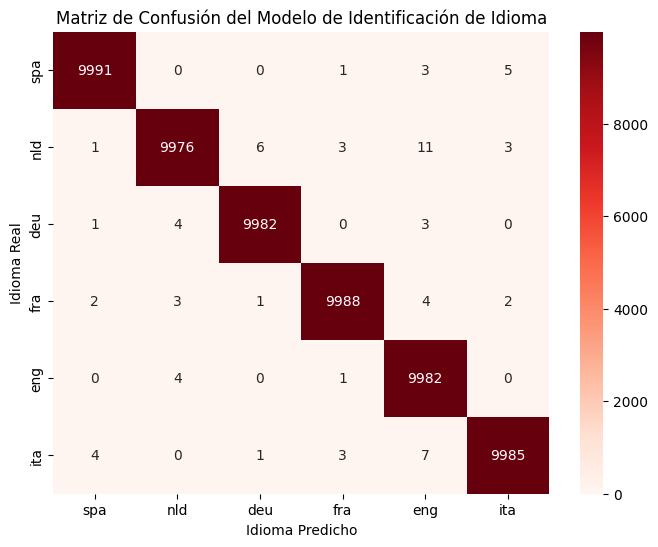

In [13]:
matriz_confusion = confusion_matrix(idioma_test_real, idiomas_predichos, labels=list(set(idioma_test_real)))

# Mostrar la matriz de confusión en formato gráfico
plt.figure(figsize=(8,6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Reds", xticklabels=list(set(idioma_test_real)), yticklabels=list(set(idioma_test_real)))
plt.xlabel("Idioma Predicho")
plt.ylabel("Idioma Real")
plt.title("Matriz de Confusión del Modelo de Identificación de Idioma")
plt.show()

<div style="text-align: justify;">
Com es pot observar a la matriu de confusió, cada idioma ha estat identificat correctament en més del 99.75% dels casos, cosa que demostra que el model és robust i altament fiable. La gran majoria dels valors de la diagonal principal estan propers a 10000 (nombre de frases als conjunts test), fet que indica que les frases han estat classificades correctament gairebé en la seva totalitat.

A més a més, les cel·les fora de la diagonal principal representen els errors, és a dir, els casos en què el model ha assignat un idioma incorrecte. Tot i això, aquests errors són escassos i no semblen concentrar-se en un idioma concret, cosa que suggereix que el model no presenta biaixos significatius cap a cap idioma en particular.

Alguns exemples d'errors observats són:

- Francès (fra): De 10.000 frases, 12 han estat classificades incorrectament en total, amb petits errors en alemany (deu), anglès (eng) i neerlandès (nld).
- Alemany (deu): Ha presentat 8 errors en total, distribuïts en idiomes propers com el neerlandès i l’anglès.
- Neerlandès (nld): Ha tingut 21 errors, amb la majoria assignats incorrectament com a anglès (eng) o alemany (deu).
- Anglès (eng): Només 5 frases van ser classificades incorrectament.
- Espanyol (spa) i Italià (ita): Tot i la seva similitud lingüística, els errors entre ells van ser mínims (només 5 i 4 respectivament).

S'han de tenir en compte possibles errors en la classificació entre idiomes amb similituds fonètiques i estructurals, com és el cas de:

- El neerlandès i l’alemany, que comparteixen moltes arrels lèxiques, fet que explica que algunes frases en neerlandès siguin classificades erròniament com a alemany i viceversa.
- L’espanyol i l’italià, que tenen estructures gramaticals i vocabularis similars, fet que pot haver contribuït als errors entre ells.

Tot i així, els errors que poden ser causats per aquests motius segueixen essent insignificants davant la gran presició del model.


En resum, l’anàlisi dels resultats demostra que el model d'identificació d’idioma és altament precís, assolint un accuracy del 99.88% en la classificació de frases. La matriu de confusió confirma que la majoria dels idiomes han estat identificats correctament, amb errors mínims que es concentren principalment en idiomes amb similituds lèxiques i estructurals.

Tot i que els errors són escassos, és important destacar que aquests es produeixen principalment en parelles d'idiomes amb característiques compartides, com el neerlandès i l’alemany o l’espanyol i l’italià. Aquest patró suggereix que el model funciona correctament en la majoria dels casos, però que podria beneficiar-se d’un ajustament més fi en idiomes propers.

En general, el rendiment del model és molt satisfactori i resulta adequat per aplicacions pràctiques en processament del llenguatge natural. Els pocs errors observats no comprometen la seva funcionalitat i, amb algunes millores, podria assolir una precisió encara més alta.
</div>